# **Proyecto IA**

Juan David Cetina, Mariana Salas, Santiago Sabogal

## **Introducción**

En este proyecto se desarrolló, entrenó y evaluó un agente para el juego de Connect4 utilizando técnicas de aprendizaje por refuerzo. El objetivo principal fue construir una política capaz de tomar decisiones racionales a partir de la experiencia, empleando una Q-table aprendida mediante Q-learning tabular. Para ello, se implementó un entorno de juego completo y se diseñó un proceso de entrenamiento donde el agente juega 12,000 partidas contra un oponente heurístico. Durante este proceso, el agente aplica una estrategia UCB para equilibrar exploración y explotación, actualiza sus Q-values después de cada episodio y genera un archivo de modelo (*connect4_model.json*) que recoge el conocimiento adquirido.

Posteriormente, se integró esta Q-table en una policy final que combina tres elementos: búsqueda táctica de victorias y bloqueos inmediatos, consulta de los valores aprendidos, y una heurística basada en la centralidad del tablero para resolver estados no vistos. Asimismo, se generaron visualizaciones y métricas que permiten evaluar la evolución del agente, como curvas de recompensa, longitudes de partida, tasas de victoria frente al oponente heurístico y estadísticas completas de visitas y Q-values. Finalmente, el modelo entrenado fue utilizado para validar que la policy se vuelve progresivamente más racional y consistente, mostrando un comportamiento coherente con la dinámica del aprendizaje reforzado.

## **Metodología**

La metodología aplicada en este proyecto integra conceptos teóricos de toma de decisiones secuenciales, procesos de decisión de Markov y aprendizaje por refuerzo. El objetivo es desarrollar un agente para Connect4 que combine aprendizaje tabular con heurísticas tácticas para lograr un comportamiento útil y competitivo.

### **Propuestas iniciales**

### **MDP**

El juego Conenect4 se formuló como un Proceso de Decisión de Markov (MDP):

- **Estados \( S \):** Todas las configuraciones del tablero de 6 X 7, junto con el jugador al que le corresponde mover.
- **Acciones \( A \):** Columnas legales donde puede colocarse una ficha.
- **Transiciones \( P(s'| s, a) \):** Deterministas, porque una jugada siempre produce el mismo estado.
- **Recompensas \( r(s) \):**
  - \( +1 \) si el agente gana.
  - \( -1 \) si pierde.
  - \( 0 \) en transiciones intermedias y empates.
- **Factor de descuento:** 0.95.

A continuación, se muestran fórmulas importantes a tener en cuenta.

$$
v^\pi(s) = \mathbb{E}\left[\sum_{t=0}^{\infty} \gamma^t \, r(S_t)\right]
$$

$$
q^\pi(s,a) = r(s) + \gamma \sum_{s'} P(s' \mid s,a)\, v^\pi(s')
$$

### **Política final**

La política final implementada en *CetinaSalasSabogal* combina dos componentes principales:  
* **Heurística táctica**: Diseñada para detectar oportunidades de victoria y amenazas inmediatas. 
* **Q-table:** Aprendida durante el entrenamiento para seleccionar acciones con base en los valores Q almacenados.  

Este enfoque sigue el esquema de General Policy Iteration (GPI), ya que la política mejora mediante valores aprendidos, pero recurre a reglas tácticas cuando no posee información suficiente para un estado. Antes de cada partida, el método *mount()* intenta cargar, si existe, el archivo con el aprendizaje: *connect4_model.json*. Si el archivo no existe, contiene errores o está vacío, la Q-table se inicializa y la política opera únicamente con heurística.

Cuando sí existe información para el estado actual, la política selecciona:

$$
\pi(s) = \arg\max_{a \in A(s)} Q(s,a)
$$

El proceso es:

1. Codificar el estado con *codificar_posicion(tablero)*.  
2. Recuperar *self._q[estado]* si existe.  
3. Filtrar solo las acciones legales.  
4. Elegir la columna con mayor Q-valor.

Cuando no hay Q-valores útiles para el estado actual, la policy usa una heurística determinista compuesta por tres pasos:

* Buscar victoria inmediata, donde para cada columna legal se simula la jugada (*simular_caida*), se evalúa si produce un cuatro en línea usando *cuatro_en_linea()* y, si es victoria, juega esa columna inmediatamente.

* Bloquear victoria del rival, donde si el rival puede ganar en su próximo turno se identifica la columna peligrosa y se juega ahí para bloquear y evitar la derrota.

* Prioridad posicional, ya que si no hay ataques ni amenazas inmediatas, la política aplica esta prioridad de:
    1. Centro  
    2. Columnas adyacentes  
    3. Columnas intermedias  
    4. Esquinas

### **Política de entrenamiento**

Para el entrenamiento se implementa un esquema de aprendizaje por refuerzo en el que el agente aprende una tabla Q sobre el juego Conecta 4, con una estrategia de Upper Confidence Bound (UCB). El objetivo es equilibrar la explotación (usar las acciones con mejor valor estimado) y exploración (probar acciones de las que se tiene menos información). El entorno se modela como un MDP, como se mencionó anteriormente.

El entrenamiento utiliza un oponente determinista, que actúa como baseline y permite evaluar si el agente aprende a superar otras estrategias. Este oponente replica una política heurística de Connect4 basada en las siguientes reglas tácticas:

1. **Victoria inmediata:** Si existe una jugada ganadora en el turno actual, la ejecuta.
2. **Bloqueo inmediato:** Si el rival tiene una jugada ganadora en su siguiente turno, la bloquea.
3. **Prioridad posicional:** Prefiere jugar en columnas centrales (mejor control y más combinaciones posibles).
4. **Evitar derrotas inmediatas:** Identifica jugadas que le darían al rival una victoria automática y las evita cuando es posible.

Esta política garantiza que el agente se entrene contra un oponente consistente, lo que permite al algoritmo Q-learning aprender patrones de ataque y defensa más complejos.

Acerca del UCB, este se implementa mediante la fórmula:

$$
\text{UCB}(s,a) \;=\; Q(s,a) \;+\; c \sqrt{\frac{\ln N(s)}{N(s,a)}}
$$

- **\(Q(s,a)\):** Es el valor aprendido para la acción.
- **\(N(s,a)\):** Es el número de veces que se ha elegido la acción \(a\) en el estado \(s\).
- **\(N(s)\):** Es el número total de visitas a ese estado.
- **\(c\):** Es el parámetro de exploración (c = 1.4), siguiendo el recomendado en las diapositivas de clase.

Siguiendo esta estrategia, la política exploratoria del agente queda definida como:

$$
\pi_{\text{UCB}}(s) \;=\; 
\arg\max_{a \in A(s)} \left[ Q(s,a) + c \sqrt{\frac{\ln N(s)}{N(s,a)}} \right].
$$

Esta regla de decisión permite que el agente explore de forma inteligente y adaptativa, priorizando acciones poco investigadas. Los valores generados se van actualizando en la tabla.

## **Resultados**

### **Validación del agente**

In [114]:
# Importación de librerías

import os
import glob
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Cargar los JSON

def cargar_json(path):
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)
    
versiones = ["VS1_Mejorada", "VS2_Mejorada", "VS3_Mejorada"]

curva_paths = {}
selfplay_paths = {}
qstats_paths = {}

for vs in versiones:
    curva_files = glob.glob(os.path.join(vs, "curva_vs_heuristic_medium_ucb*.json"))
    selfplay_files = glob.glob(os.path.join(vs, "selfplay_qlearning_ucb_vs_heuristic_medium_*.json"))
    qstats_files = glob.glob(os.path.join(vs, "qstats_completo_ucb*.json"))

    if not curva_files:
        print(f"[WARN] No encontré curva en {vs}")
        continue
    if not selfplay_files:
        print(f"[WARN] No encontré selfplay en {vs}")
        continue

    if not qstats_files:
        print(f"[WARN] No encontré qstats en {vs}")
        continue

    curva_paths[vs] = sorted(curva_files)[0]
    selfplay_paths[vs] = sorted(selfplay_files)[0]
    qstats_paths[vs] = sorted(qstats_files)[0]

curva_paths, selfplay_paths, qstats_paths

[WARN] No encontré curva en VS3_Mejorada


({'VS1_Mejorada': 'VS1_Mejorada\\curva_vs_heuristic_medium_ucb_20251123_120409.json',
  'VS2_Mejorada': 'VS2_Mejorada\\curva_vs_heuristic_medium_ucb_20251123_125509.json'},
 {'VS1_Mejorada': 'VS1_Mejorada\\selfplay_qlearning_ucb_vs_heuristic_medium_20251123_120409.json',
  'VS2_Mejorada': 'VS2_Mejorada\\selfplay_qlearning_ucb_vs_heuristic_medium_20251123_125509.json'},
 {'VS1_Mejorada': 'VS1_Mejorada\\qstats_completo_ucb_20251123_120409.json',
  'VS2_Mejorada': 'VS2_Mejorada\\qstats_completo_ucb_20251123_125509.json'})

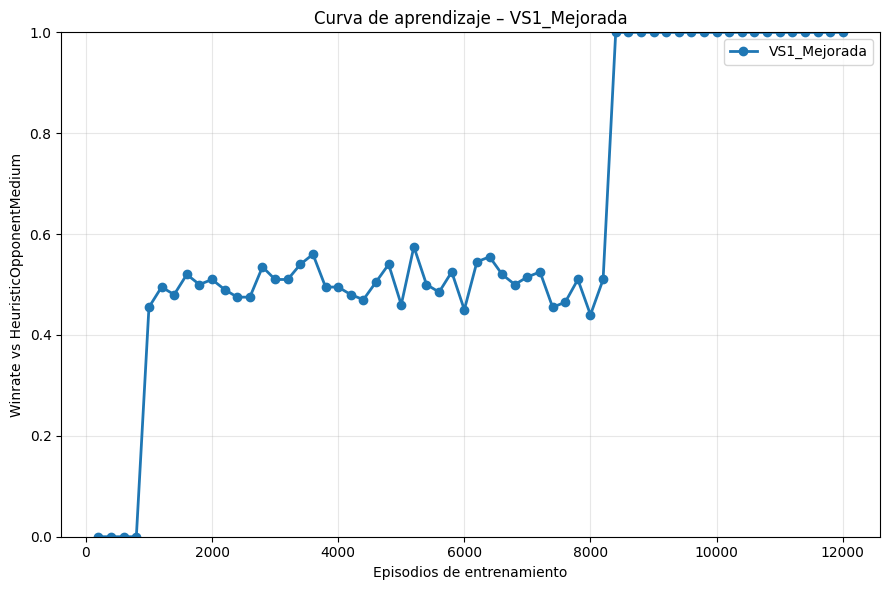

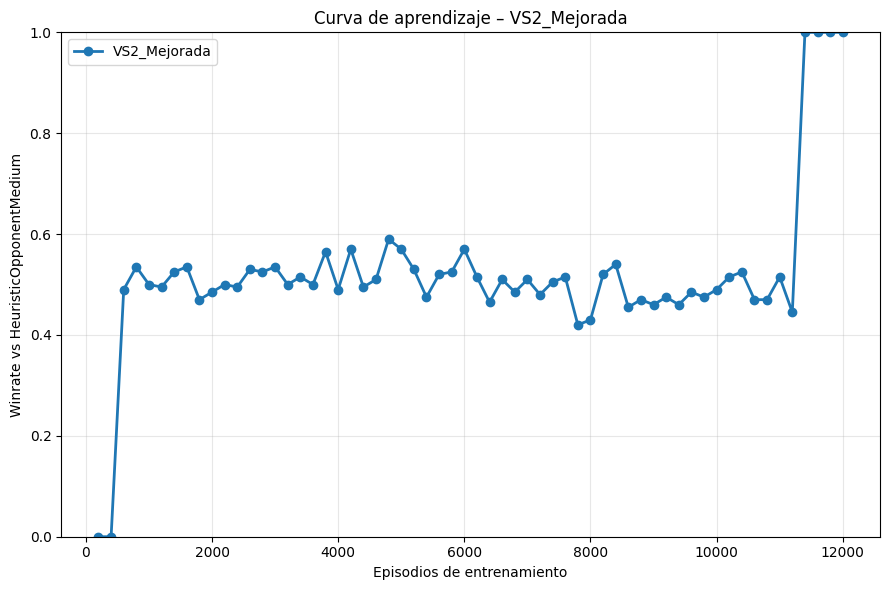

In [115]:
for vs, path in curva_paths.items():
    data = cargar_json(path)
    hist = data["historial"]

    episodios = [p["episodios"] for p in hist]
    winrates  = [p["winrate"] for p in hist]

    plt.figure(figsize=(9,6))
    plt.plot(episodios, winrates, marker="o", linewidth=2, label=f"{vs}")
    
    plt.xlabel("Episodios de entrenamiento")
    plt.ylabel("Winrate vs HeuristicOpponentMedium")
    plt.title(f"Curva de aprendizaje – {vs}")
    plt.ylim(0.0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


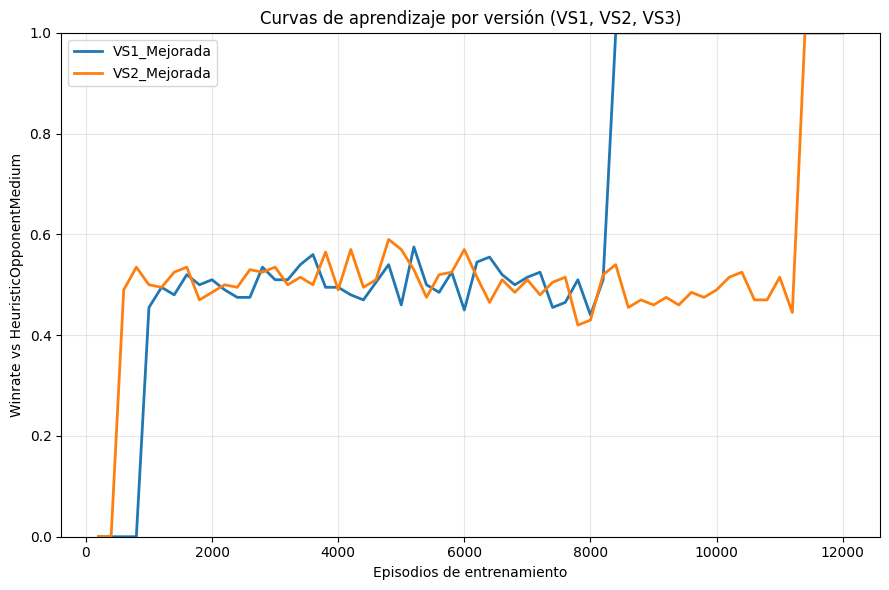

In [116]:
plt.figure(figsize=(9,6))

for vs, path in curva_paths.items():
    data = cargar_json(path)
    hist = data["historial"]                  # lista de puntos {episodios, winrate, ...}
    episodios = [p["episodios"] for p in hist]
    winrates  = [p["winrate"] for p in hist]

    plt.plot(episodios, winrates, linewidth=2, label=vs)

plt.xlabel("Episodios de entrenamiento")
plt.ylabel("Winrate vs HeuristicOpponentMedium")
plt.title("Curvas de aprendizaje por versión (VS1, VS2, VS3)")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [117]:
registros = []

for vs, path in curva_paths.items():
    data = cargar_json(path)
    hist = data["historial"]
    for p in hist:
        registros.append({
            "version": vs,
            "episodios": p["episodios"],
            "winrate": p["winrate"],
        })

df_curvas = pd.DataFrame(registros)
df_curvas.head()

stats_win = (
    df_curvas
    .groupby("episodios")["winrate"]
    .agg(["mean", "std"])
    .reset_index()
)
stats_win

stats_win = (
    df_curvas
    .groupby("episodios")["winrate"]
    .agg(["mean", "std"])
    .reset_index()
)
stats_win

,episodios,mean,std
0,200,0.0000,0.000000
1,400,0.0000,0.000000
2,600,0.2450,0.346482
3,800,0.2675,0.378302
4,1000,0.4775,0.031820
5,1200,0.4950,0.000000
6,1400,0.5025,0.031820
7,1600,0.5275,0.010607
8,1800,0.4850,0.021213
9,2000,0.4975,0.017678


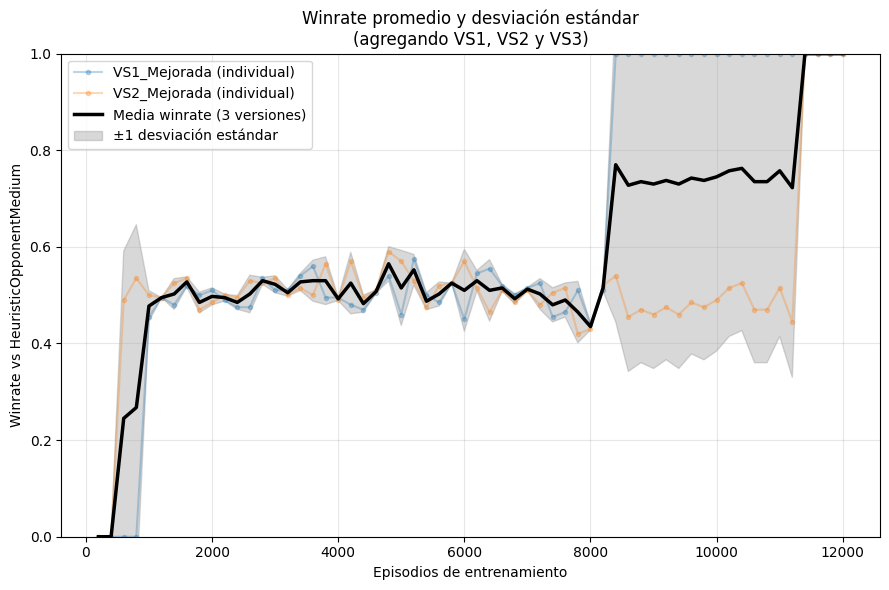

In [118]:
plt.figure(figsize=(9,6))

# Curvas individuales (semi transparentes)
for vs, sub in df_curvas.groupby("version"):
    plt.plot(sub["episodios"], sub["winrate"], ".-", alpha=0.3, label=f"{vs} (individual)")

# Media y desviación estándar
plt.plot(stats_win["episodios"], stats_win["mean"],
         color="black", linewidth=2.5, label="Media winrate (3 versiones)")

upper = stats_win["mean"] + stats_win["std"]
lower = stats_win["mean"] - stats_win["std"]

plt.fill_between(stats_win["episodios"], lower, upper,
                 color="gray", alpha=0.3, label="±1 desviación estándar")

plt.xlabel("Episodios de entrenamiento")
plt.ylabel("Winrate vs HeuristicOpponentMedium")
plt.title("Winrate promedio y desviación estándar\n(agregando VS1, VS2 y VS3)")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

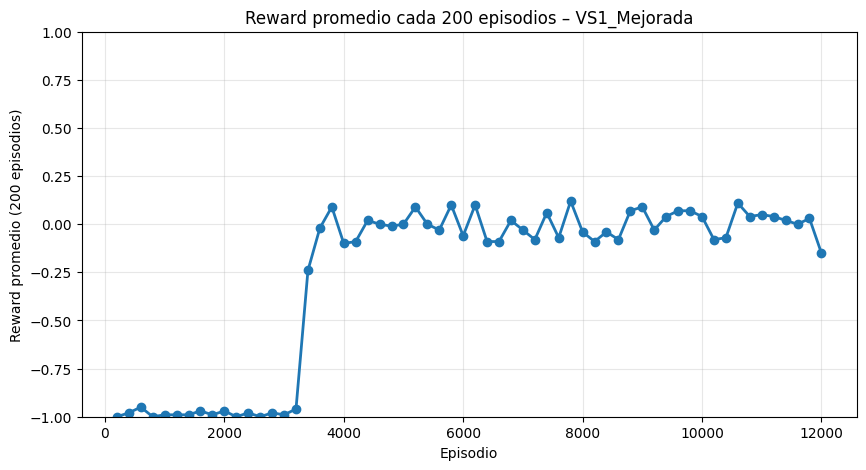

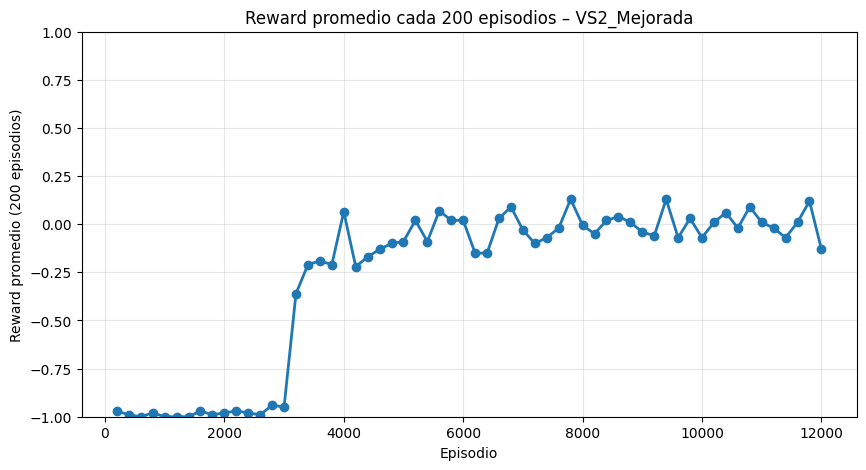

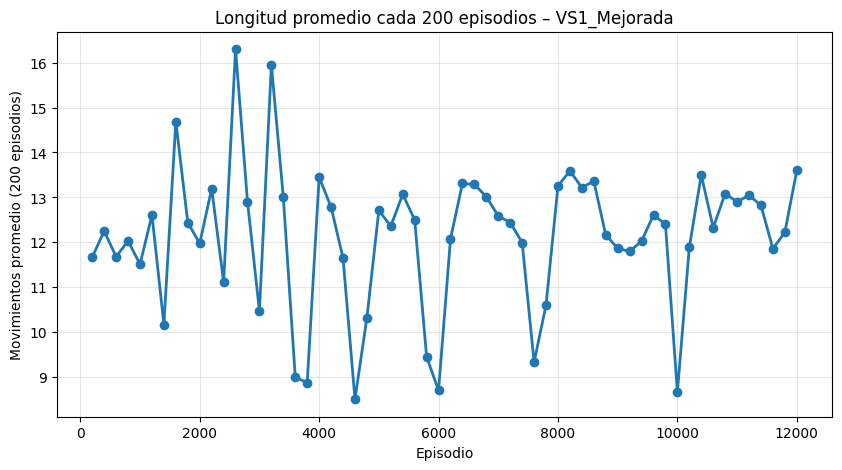

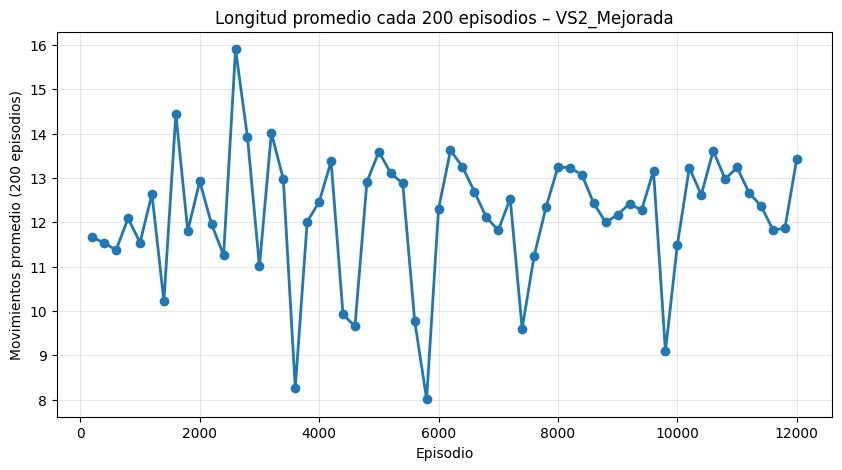

In [119]:
def promedio_por_bloques(valores, episodios, tamaño_bloque=200):
    """Promedia valores cada 'tamaño_bloque' episodios."""
    bloques_x = []
    bloques_y = []

    inicio = 0
    n = len(valores)

    while inicio < n:
        fin = min(inicio + tamaño_bloque, n)
        bloque = valores[inicio:fin]
        bloque_epi = episodios[inicio:fin]

        bloques_x.append(bloque_epi[-1])  # último episodio del bloque
        bloques_y.append(np.mean(bloque))

        inicio = fin

    return bloques_x, bloques_y


# -------------------------------------------------------------------
# GRAFICAR REWARD PROMEDIADO CADA 200 EPISODIOS PARA CADA VS
# -------------------------------------------------------------------
for vs, path in selfplay_paths.items():
    data = cargar_json(path)

    episodios = data["episodios"]
    recompensas = data["recompensas"]

    x_avg, y_avg = promedio_por_bloques(recompensas, episodios, tamaño_bloque=200)

    plt.figure(figsize=(10,5))
    plt.plot(x_avg, y_avg, marker="o", linewidth=2, label=f"{vs}")
    plt.title(f"Reward promedio cada 200 episodios – {vs}")
    plt.xlabel("Episodio")
    plt.ylabel("Reward promedio (200 episodios)")
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)
    plt.show()



# -------------------------------------------------------------------
# GRAFICAR LONGITUD PROMEDIADA CADA 200 EPISODIOS PARA CADA VS
# -------------------------------------------------------------------
for vs, path in selfplay_paths.items():
    data = cargar_json(path)

    episodios = data["episodios"]
    longitudes = data["longitudes"]

    x_avg, y_avg = promedio_por_bloques(longitudes, episodios, tamaño_bloque=200)

    plt.figure(figsize=(10,5))
    plt.plot(x_avg, y_avg, marker="o", linewidth=2, label=f"{vs}")
    plt.title(f"Longitud promedio cada 200 episodios – {vs}")
    plt.xlabel("Episodio")
    plt.ylabel("Movimientos promedio (200 episodios)")
    plt.grid(True, alpha=0.3)
    plt.show()


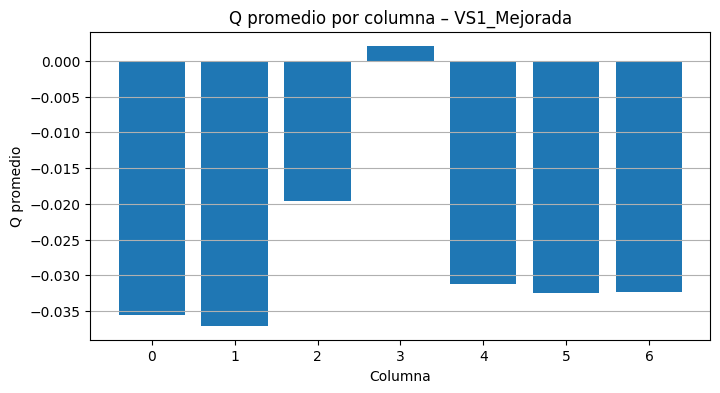

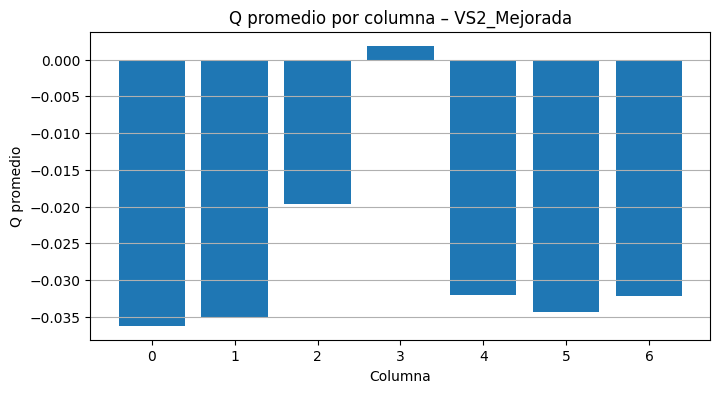

In [120]:
for vs, path in qstats_paths.items():
    data = cargar_json(path)

    Q_por_col = {col: [] for col in range(7)}

    for estado, acciones in data.items():
        for a_str, info in acciones.items():
            col = int(a_str)
            Q_por_col[col].append(info["Q"])

    promedios = [np.mean(Q_por_col[c]) for c in range(7)]

    plt.figure(figsize=(8,4))
    plt.bar(range(7), promedios)
    plt.title(f"Q promedio por columna – {vs}")
    plt.xlabel("Columna")
    plt.ylabel("Q promedio")
    plt.grid(True, axis="y")
    plt.show()


### **Gradescope**

## **Optimización del Agente**

Medida propia...

Pasar de heurístico a algo que mejora

In [121]:
versiones = ["VS1", "VS2", "VS3"]

curva_paths = {}
selfplay_paths = {}
qstats_paths = {}

for vs in versiones:
    curva_files = glob.glob(os.path.join(vs, "curva_vs_heuristic_medium_*.json"))
    selfplay_files = glob.glob(os.path.join(vs, "selfplay_qlearning_vs_heuristic_medium_*.json"))
    qstats_files = glob.glob(os.path.join(vs, "qstats_completo_*.json"))

    if not curva_files:
        print(f"[WARN] No encontré curva en {vs}")
        continue
    if not selfplay_files:
        print(f"[WARN] No encontré selfplay en {vs}")
        continue

    if not qstats_files:
        print(f"[WARN] No encontré qstats en {vs}")
        continue

    curva_paths[vs] = sorted(curva_files)[0]
    selfplay_paths[vs] = sorted(selfplay_files)[0]
    qstats_paths[vs] = sorted(qstats_files)[0]

curva_paths, selfplay_paths, qstats_paths

({'VS1': 'VS1\\curva_vs_heuristic_medium_20251123_003402.json',
  'VS2': 'VS2\\curva_vs_heuristic_medium_20251122_234525.json',
  'VS3': 'VS3\\curva_vs_heuristic_medium_20251122_234938.json'},
 {'VS1': 'VS1\\selfplay_qlearning_vs_heuristic_medium_20251123_003402.json',
  'VS2': 'VS2\\selfplay_qlearning_vs_heuristic_medium_20251122_234525.json',
  'VS3': 'VS3\\selfplay_qlearning_vs_heuristic_medium_20251122_234938.json'},
 {'VS1': 'VS1\\qstats_completo_20251123_003402.json',
  'VS2': 'VS2\\qstats_completo_20251122_234525.json',
  'VS3': 'VS3\\qstats_completo_20251122_234938.json'})

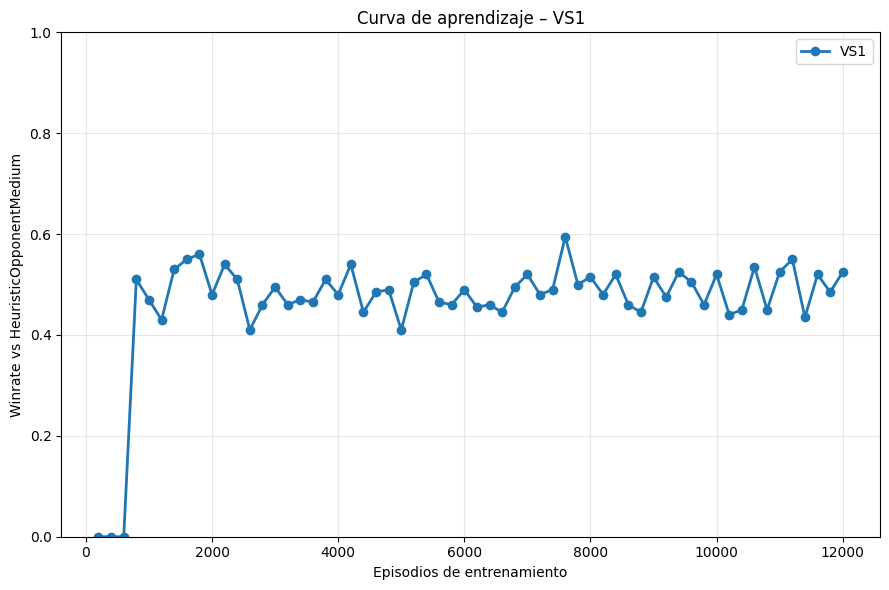

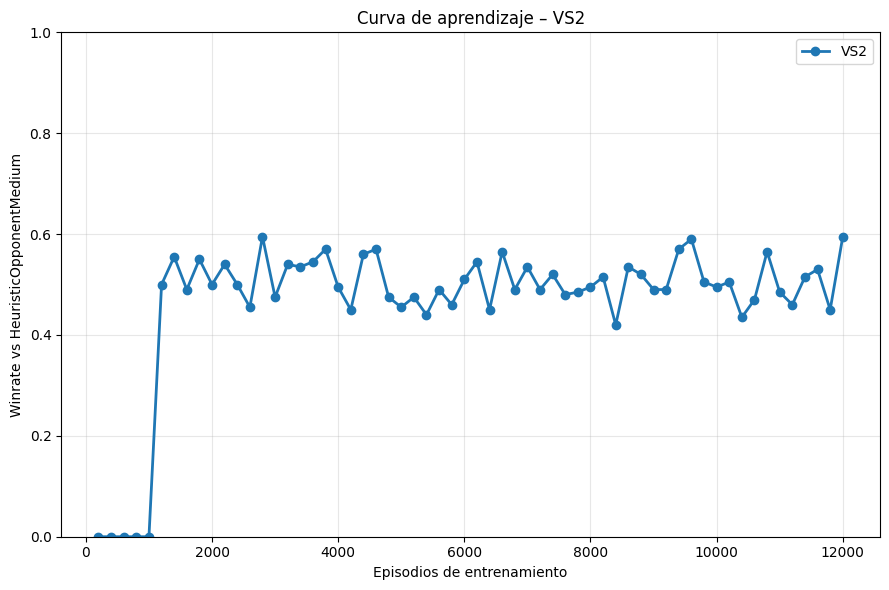

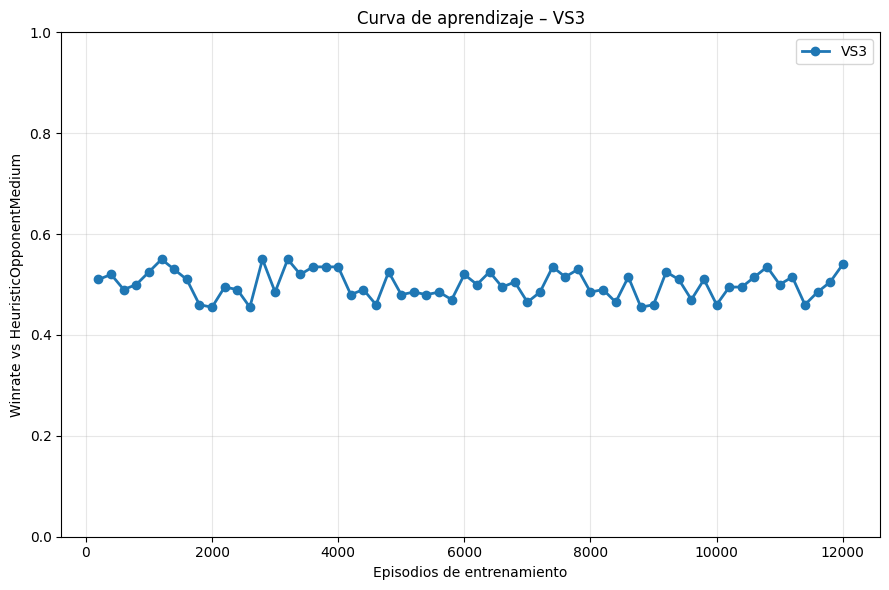

In [122]:
for vs, path in curva_paths.items():
    data = cargar_json(path)
    hist = data["historial"]

    episodios = [p["episodios"] for p in hist]
    winrates  = [p["winrate"] for p in hist]

    plt.figure(figsize=(9,6))
    plt.plot(episodios, winrates, marker="o", linewidth=2, label=f"{vs}")
    
    plt.xlabel("Episodios de entrenamiento")
    plt.ylabel("Winrate vs HeuristicOpponentMedium")
    plt.title(f"Curva de aprendizaje – {vs}")
    plt.ylim(0.0, 1.0)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


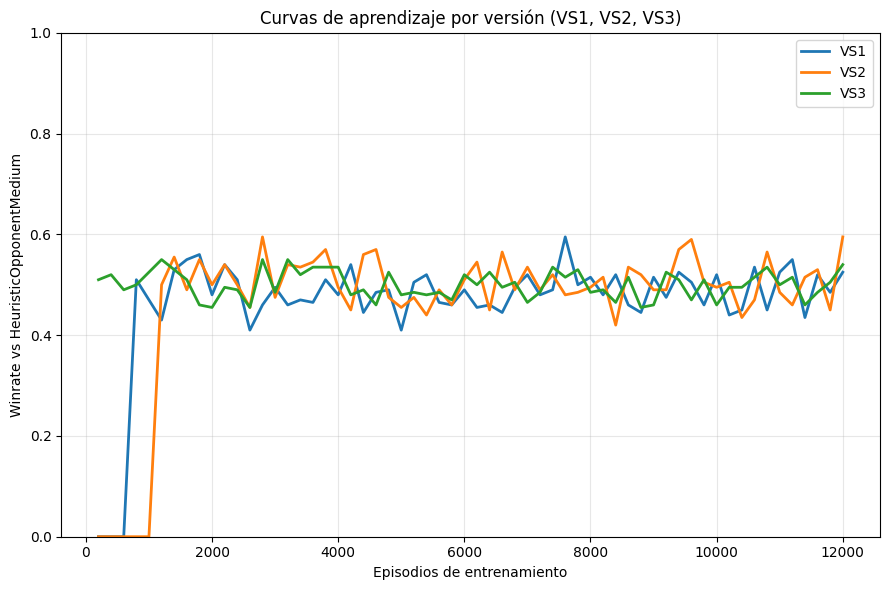

In [123]:
plt.figure(figsize=(9,6))

for vs, path in curva_paths.items():
    data = cargar_json(path)
    hist = data["historial"]                  # lista de puntos {episodios, winrate, ...}
    episodios = [p["episodios"] for p in hist]
    winrates  = [p["winrate"] for p in hist]

    plt.plot(episodios, winrates, linewidth=2, label=vs)

plt.xlabel("Episodios de entrenamiento")
plt.ylabel("Winrate vs HeuristicOpponentMedium")
plt.title("Curvas de aprendizaje por versión (VS1, VS2, VS3)")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

In [124]:
registros = []

for vs, path in curva_paths.items():
    data = cargar_json(path)
    hist = data["historial"]
    for p in hist:
        registros.append({
            "version": vs,
            "episodios": p["episodios"],
            "winrate": p["winrate"],
        })

df_curvas = pd.DataFrame(registros)
df_curvas.head()

stats_win = (
    df_curvas
    .groupby("episodios")["winrate"]
    .agg(["mean", "std"])
    .reset_index()
)
stats_win

stats_win = (
    df_curvas
    .groupby("episodios")["winrate"]
    .agg(["mean", "std"])
    .reset_index()
)
stats_win

,episodios,mean,std
0,200,0.170000,0.294449
1,400,0.173333,0.300222
2,600,0.163333,0.282902
3,800,0.336667,0.291605
4,1000,0.331667,0.288545
5,1200,0.493333,0.060277
6,1400,0.538333,0.014434
7,1600,0.516667,0.030551
8,1800,0.523333,0.055076
9,2000,0.478333,0.022546


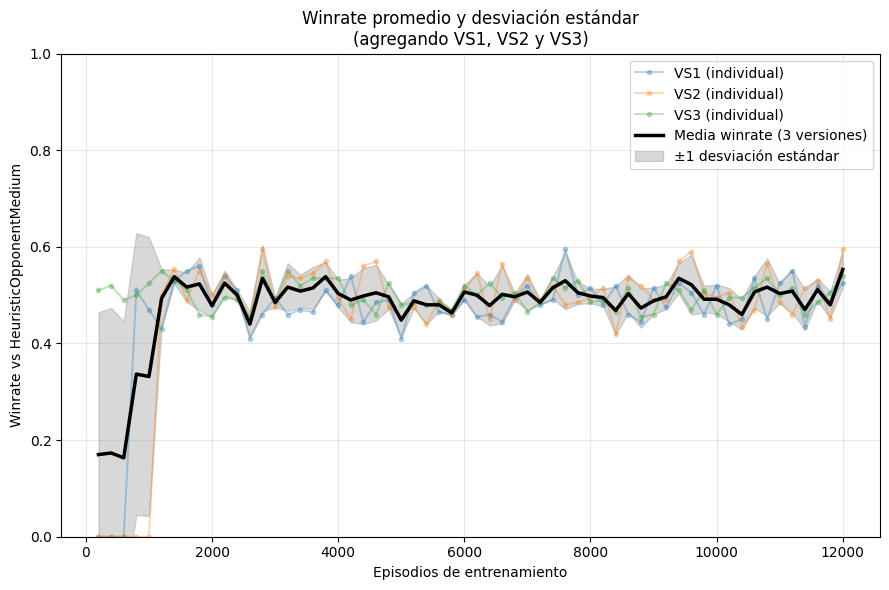

In [125]:
plt.figure(figsize=(9,6))

# Curvas individuales (semi transparentes)
for vs, sub in df_curvas.groupby("version"):
    plt.plot(sub["episodios"], sub["winrate"], ".-", alpha=0.3, label=f"{vs} (individual)")

# Media y desviación estándar
plt.plot(stats_win["episodios"], stats_win["mean"],
         color="black", linewidth=2.5, label="Media winrate (3 versiones)")

upper = stats_win["mean"] + stats_win["std"]
lower = stats_win["mean"] - stats_win["std"]

plt.fill_between(stats_win["episodios"], lower, upper,
                 color="gray", alpha=0.3, label="±1 desviación estándar")

plt.xlabel("Episodios de entrenamiento")
plt.ylabel("Winrate vs HeuristicOpponentMedium")
plt.title("Winrate promedio y desviación estándar\n(agregando VS1, VS2 y VS3)")
plt.ylim(0.0, 1.0)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

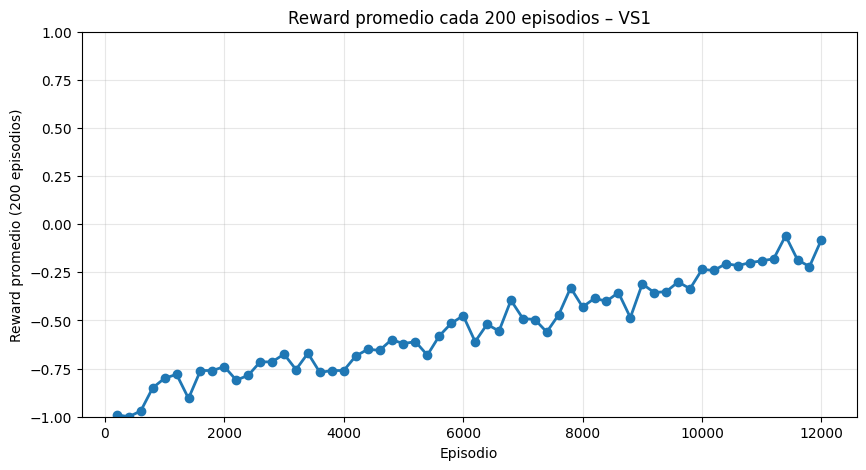

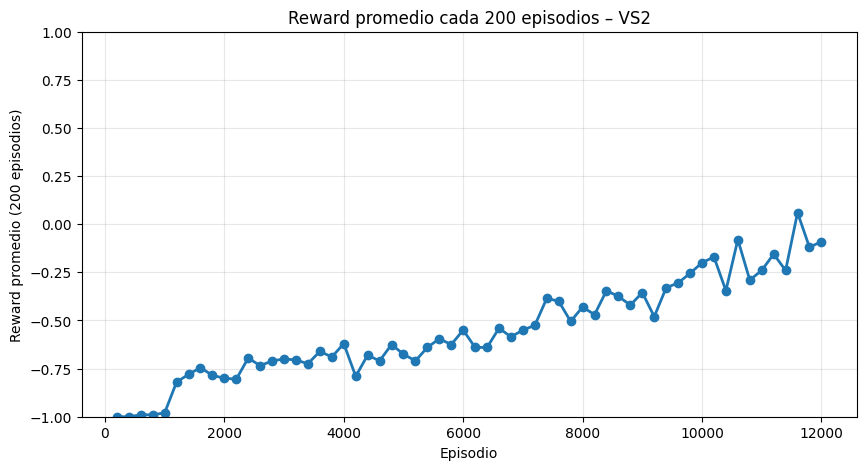

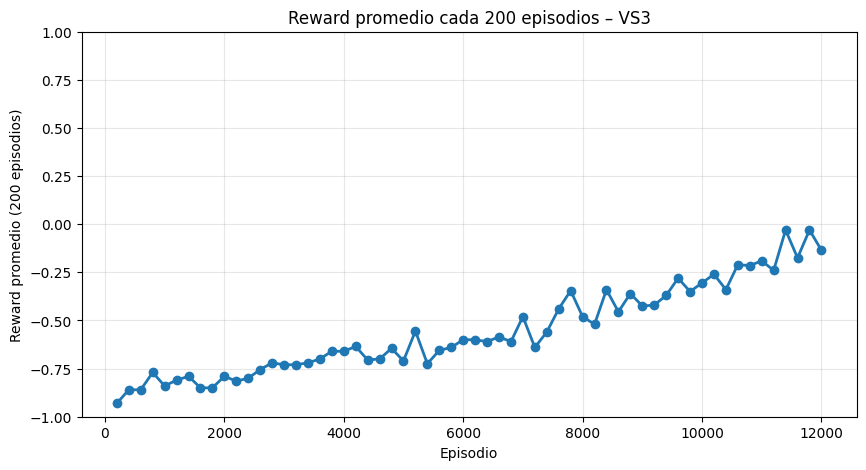

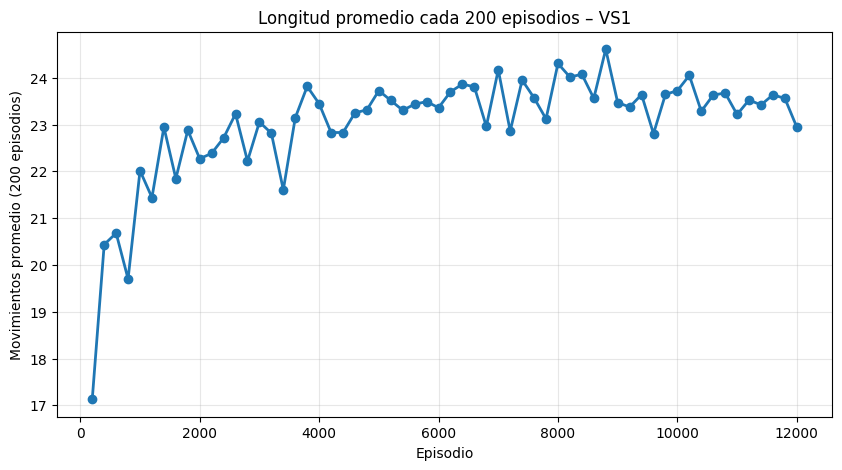

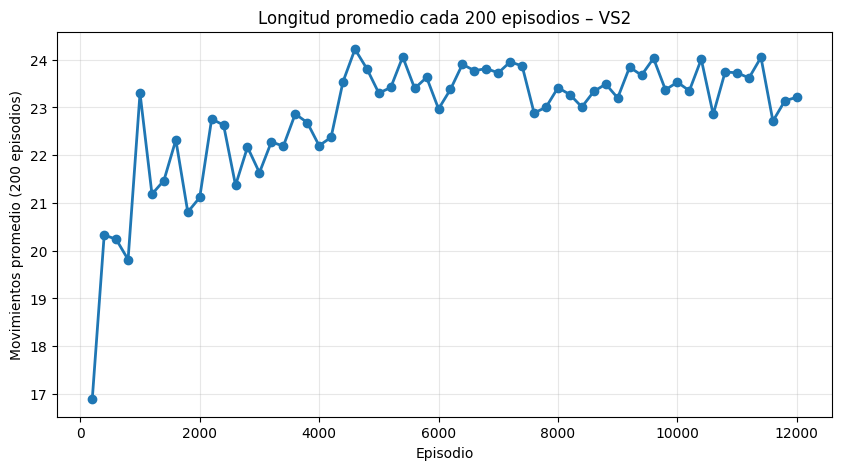

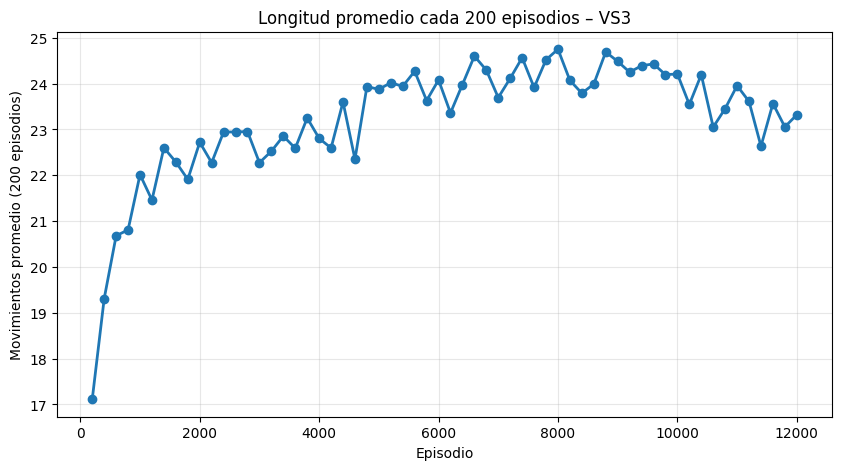

In [126]:
def promedio_por_bloques(valores, episodios, tamaño_bloque=200):
    """Promedia valores cada 'tamaño_bloque' episodios."""
    bloques_x = []
    bloques_y = []

    inicio = 0
    n = len(valores)

    while inicio < n:
        fin = min(inicio + tamaño_bloque, n)
        bloque = valores[inicio:fin]
        bloque_epi = episodios[inicio:fin]

        bloques_x.append(bloque_epi[-1])  # último episodio del bloque
        bloques_y.append(np.mean(bloque))

        inicio = fin

    return bloques_x, bloques_y


# -------------------------------------------------------------------
# GRAFICAR REWARD PROMEDIADO CADA 200 EPISODIOS PARA CADA VS
# -------------------------------------------------------------------
for vs, path in selfplay_paths.items():
    data = cargar_json(path)

    episodios = data["episodios"]
    recompensas = data["recompensas"]

    x_avg, y_avg = promedio_por_bloques(recompensas, episodios, tamaño_bloque=200)

    plt.figure(figsize=(10,5))
    plt.plot(x_avg, y_avg, marker="o", linewidth=2, label=f"{vs}")
    plt.title(f"Reward promedio cada 200 episodios – {vs}")
    plt.xlabel("Episodio")
    plt.ylabel("Reward promedio (200 episodios)")
    plt.grid(True, alpha=0.3)
    plt.ylim(-1, 1)
    plt.show()



# -------------------------------------------------------------------
# GRAFICAR LONGITUD PROMEDIADA CADA 200 EPISODIOS PARA CADA VS
# -------------------------------------------------------------------
for vs, path in selfplay_paths.items():
    data = cargar_json(path)

    episodios = data["episodios"]
    longitudes = data["longitudes"]

    x_avg, y_avg = promedio_por_bloques(longitudes, episodios, tamaño_bloque=200)

    plt.figure(figsize=(10,5))
    plt.plot(x_avg, y_avg, marker="o", linewidth=2, label=f"{vs}")
    plt.title(f"Longitud promedio cada 200 episodios – {vs}")
    plt.xlabel("Episodio")
    plt.ylabel("Movimientos promedio (200 episodios)")
    plt.grid(True, alpha=0.3)
    plt.show()


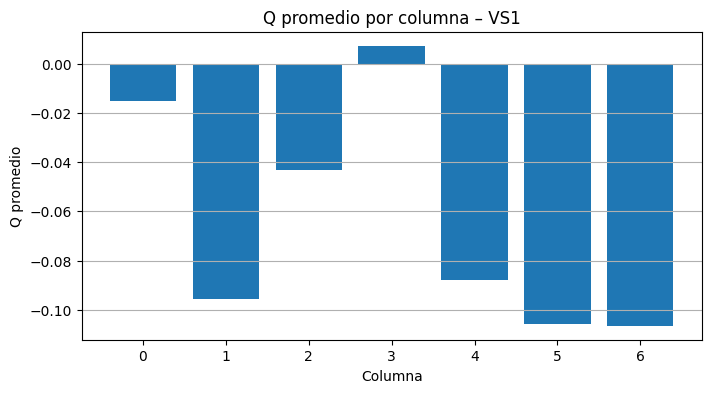

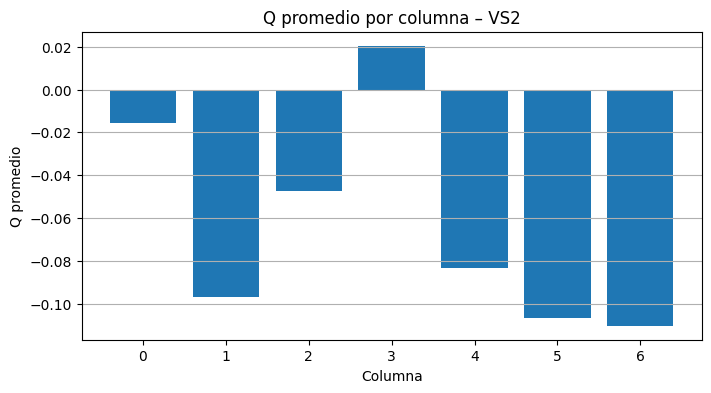

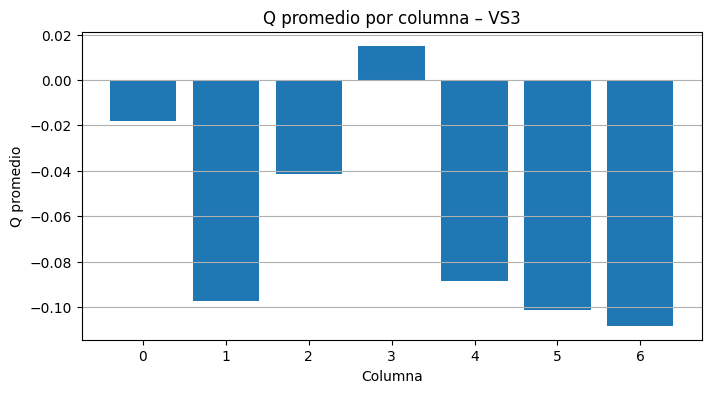

In [127]:
for vs, path in qstats_paths.items():
    data = cargar_json(path)

    Q_por_col = {col: [] for col in range(7)}

    for estado, acciones in data.items():
        for a_str, info in acciones.items():
            col = int(a_str)
            Q_por_col[col].append(info["Q"])

    promedios = [np.mean(Q_por_col[c]) for c in range(7)]

    plt.figure(figsize=(8,4))
    plt.bar(range(7), promedios)
    plt.title(f"Q promedio por columna – {vs}")
    plt.xlabel("Columna")
    plt.ylabel("Q promedio")
    plt.grid(True, axis="y")
    plt.show()


## **Reflexión y Análisis**

### **Limitaciones**

### **Mejoras**